In [27]:
from unet import *
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import scipy.io
import pandas as pd

In [28]:
Net = build_unet()
# check if CUDA is available, and set it as the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("==> Device: {}".format(device))

# move model to the device
Net.to(device)

# define loss function
# criterion = nn.L1Loss()
criterion = nn.MSELoss()

####### HYPERPARAMETERS #######

# learning rate = 10^-4
lr = 0.0001

# patch size
patch_size = 512

# define optimizer
optimizer = optim.Adam(Net.parameters(), lr=lr)

# batch size
batch_size = 1

# define number of epochs
n_epochs = 100

# keep track of the best validation loss
valid_loss_min = np.Inf

# number of epochs to wait before stopping
early_stopping = 5


##### LOSS  #######

# keep track of training and validation loss
train_loss = []
valid_loss = []

# initialize the early_stopping object
# early_stopping = EarlyStopping(patience=early_stopping, verbose=True)



==> Device: cuda


In [29]:
def random_crop(image, label, patch_size):
    """
    Crop a random patch from the image
    """
    # get the shape of the image
    h, w = image.shape[:2]

    # get the top left corner of the random crop
    x = np.random.randint(0, w - patch_size)
    y = np.random.randint(0, h - patch_size)

    # crop the image
    image = image[y:y + patch_size, x:x + patch_size]
    label = label[y:y + patch_size, x:x + patch_size]

    return image, label

In [30]:
def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    return out


In [31]:
# read the list.txt as a space separated dataframe
df = pd.read_csv('list.csv', sep=',', header=None)

# split df into input, label columns
input_df = df.iloc[:, 0]
label_df = df.iloc[:, 1]

# create a list of tuples
image_label_list = list(zip(input_df, label_df))

# create a dataset object
dataset = Dataset()

# create a dataloader object
dataloader = DataLoader(image_label_list, batch_size=batch_size, shuffle=False)

  0%|          | 0/100 [00:00<?, ?it/s]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')


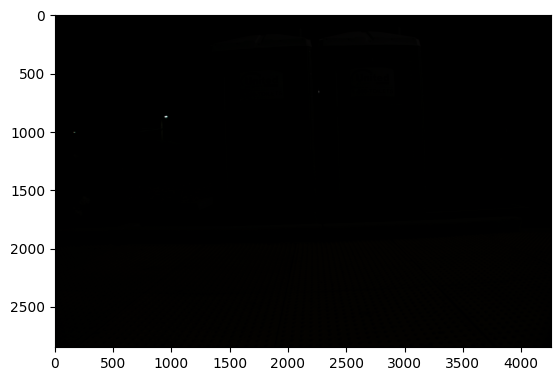

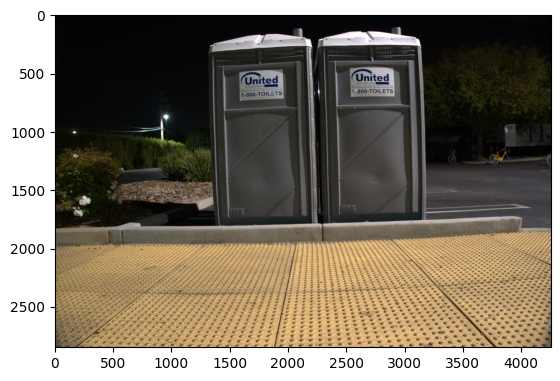

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_05_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_06_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_07_0.1s

  1%|          | 1/100 [00:13<21:38, 13.12s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

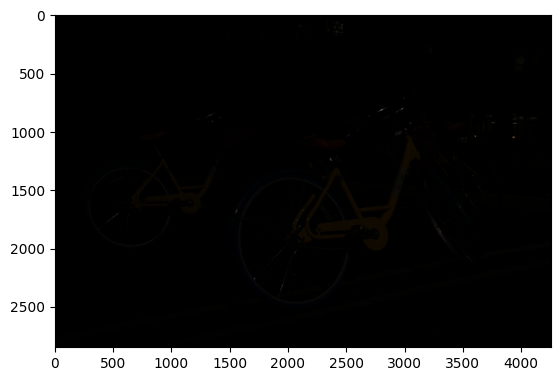

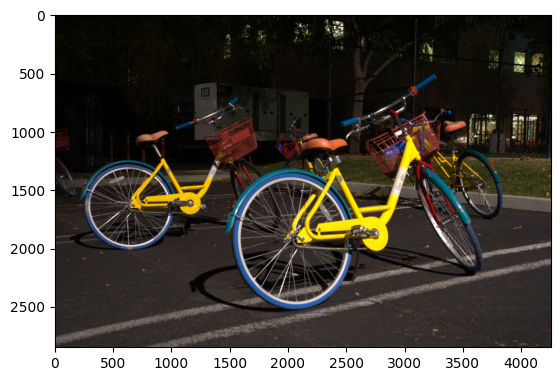

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_07_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_08_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_09_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_01_0.

  2%|▏         | 2/100 [00:25<20:45, 12.71s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

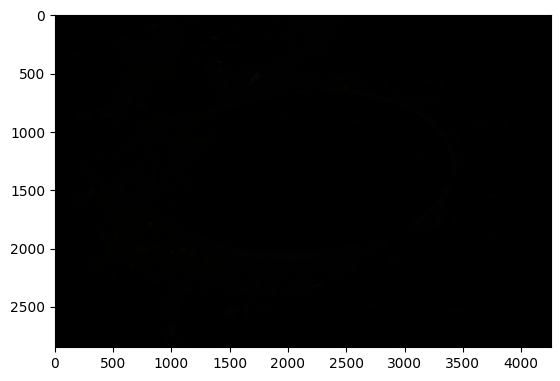

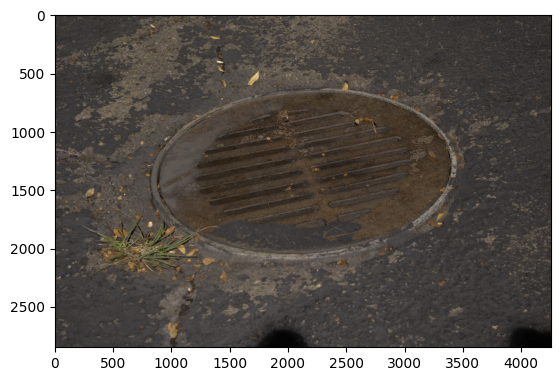

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00099_08_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00174_05_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00206_06_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00099_00_30s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00174_00_30s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00206_00_10s.ARW')


  3%|▎         | 3/100 [00:38<20:24, 12.62s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

  4%|▍         | 4/100 [00:48<18:52, 11.79s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

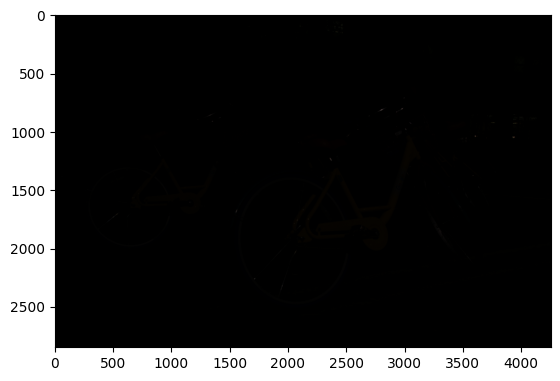

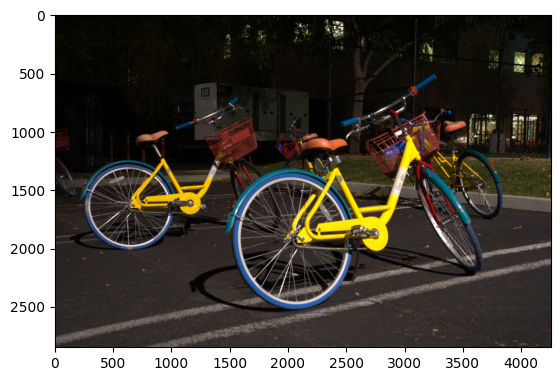

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_04_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_05_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_06_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_07_0.1s

  5%|▌         | 5/100 [01:01<19:03, 12.03s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

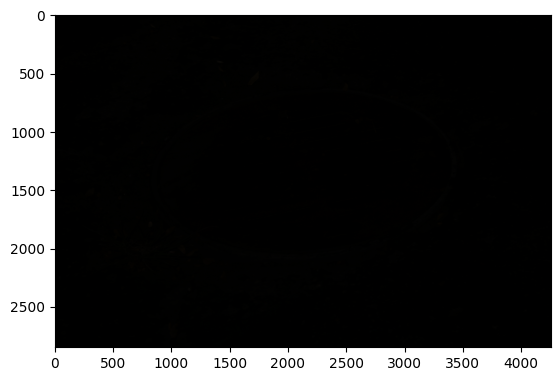

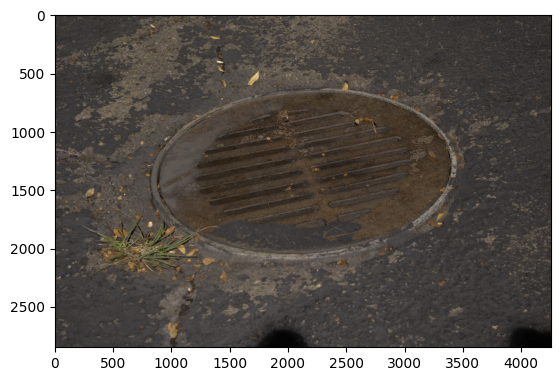

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_06_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_07_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_08_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_09_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00010_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00021_04_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00010_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00021_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00099_08_0.1s

  6%|▌         | 6/100 [01:13<19:10, 12.23s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

  7%|▋         | 7/100 [01:24<18:16, 11.79s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

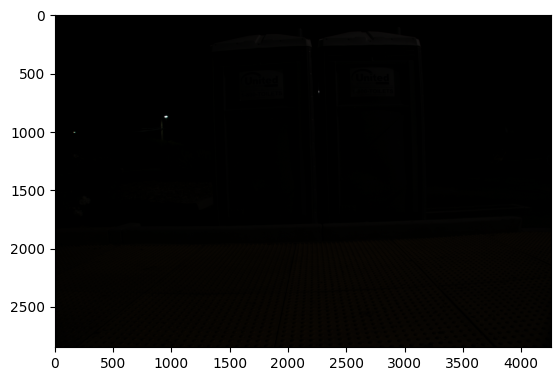

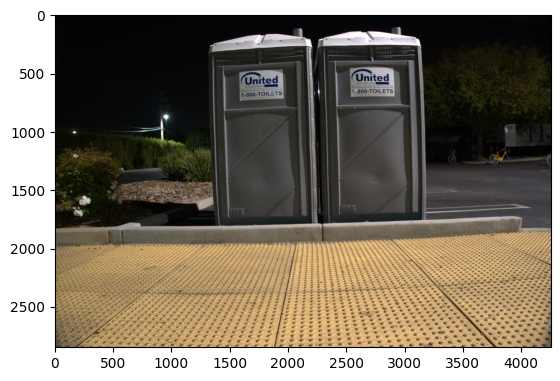

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_07_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_08_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_09_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_01_0.

  8%|▊         | 8/100 [01:37<18:27, 12.04s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

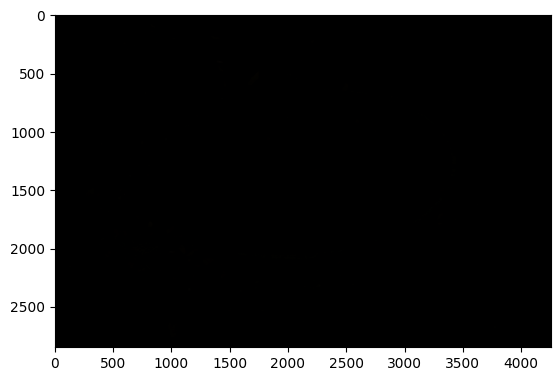

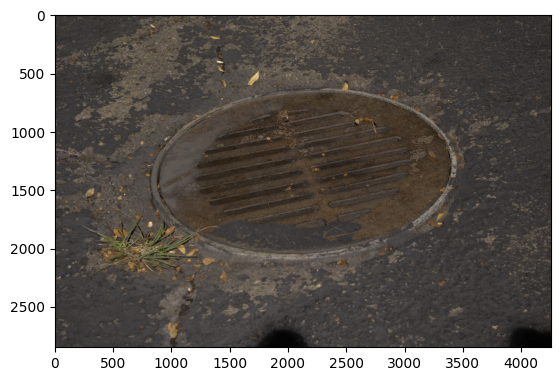

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_02_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_02_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_03_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_04_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_05_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_06_0.1

  9%|▉         | 9/100 [01:49<18:37, 12.28s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

 10%|█         | 10/100 [02:00<17:51, 11.90s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')


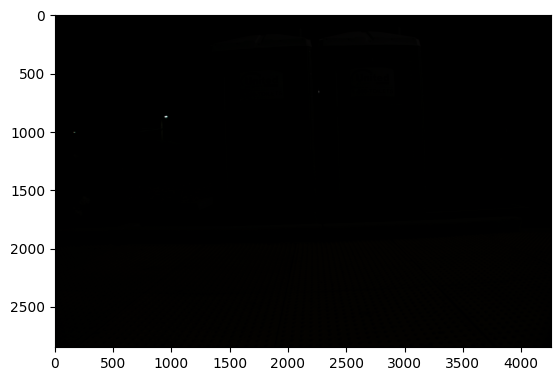

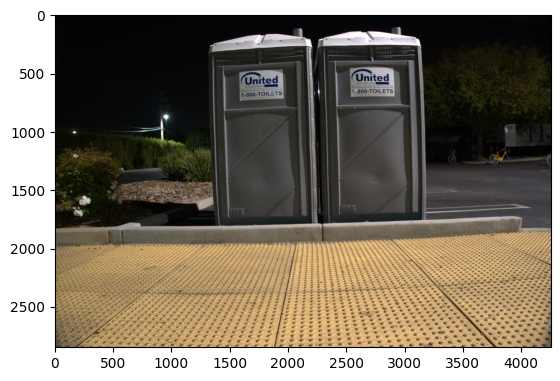

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_05_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_06_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_07_0.1s

 11%|█         | 11/100 [02:13<17:59, 12.13s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

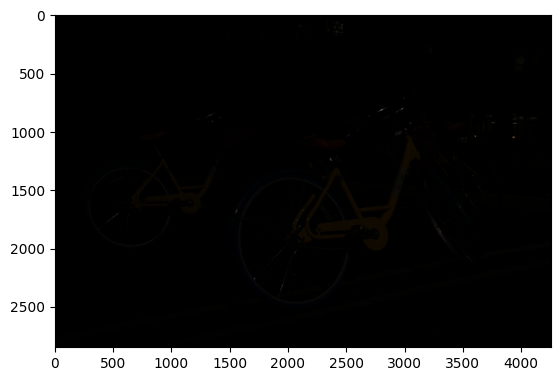

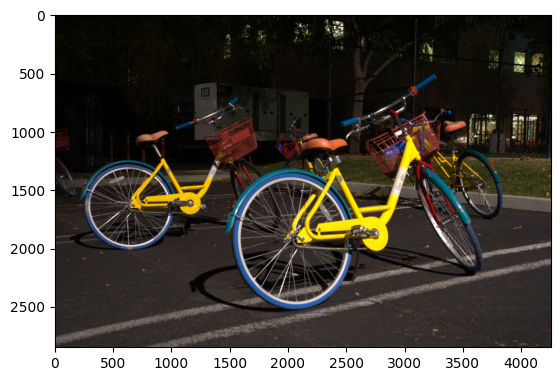

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_07_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_08_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_09_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_01_0.

 12%|█▏        | 12/100 [02:26<18:13, 12.43s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

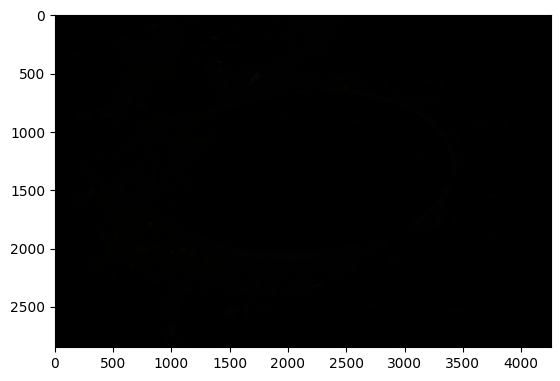

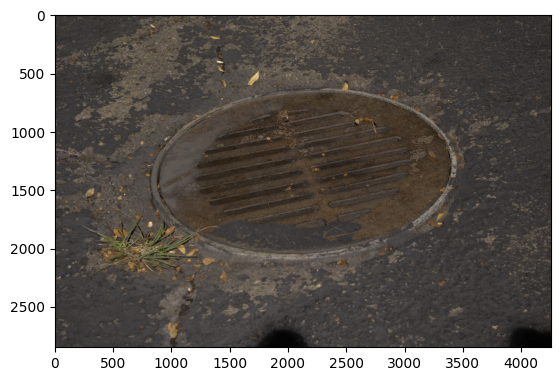

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00099_08_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00174_05_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00206_06_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00099_00_30s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00174_00_30s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00206_00_10s.ARW')


 13%|█▎        | 13/100 [02:39<18:15, 12.59s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

 14%|█▍        | 14/100 [02:50<17:11, 12.00s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

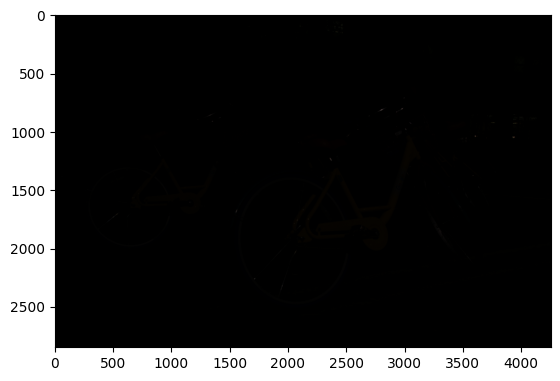

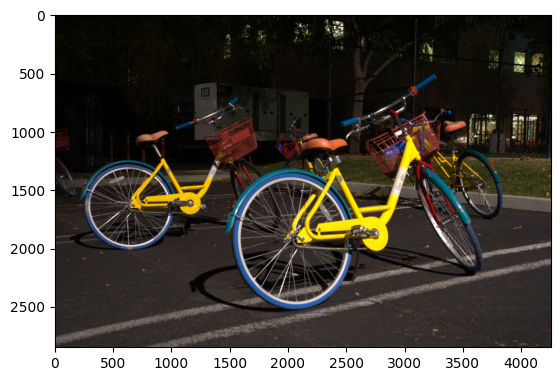

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_04_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_05_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_06_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_07_0.1s

 15%|█▌        | 15/100 [03:03<17:37, 12.44s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

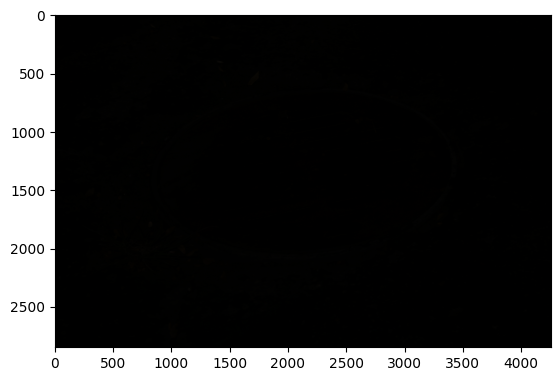

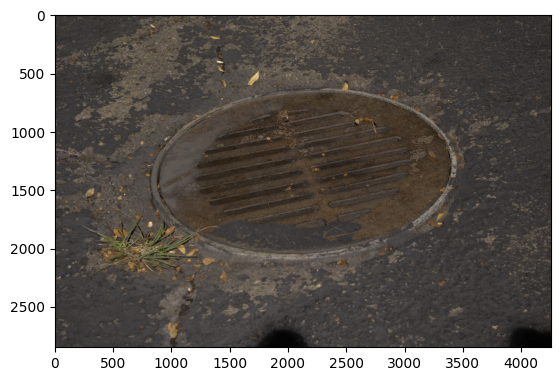

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_06_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_07_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_08_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_09_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00010_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00021_04_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00010_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00021_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00099_08_0.1s

 16%|█▌        | 16/100 [03:16<17:29, 12.50s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

 17%|█▋        | 17/100 [03:27<16:36, 12.00s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

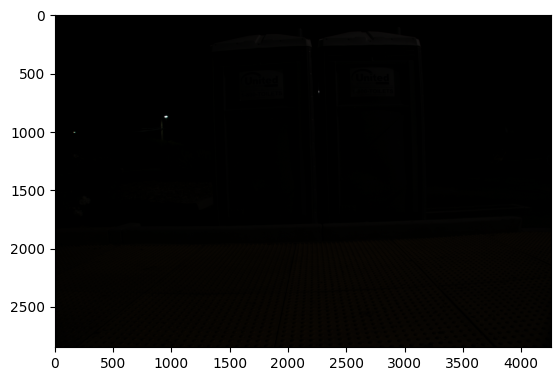

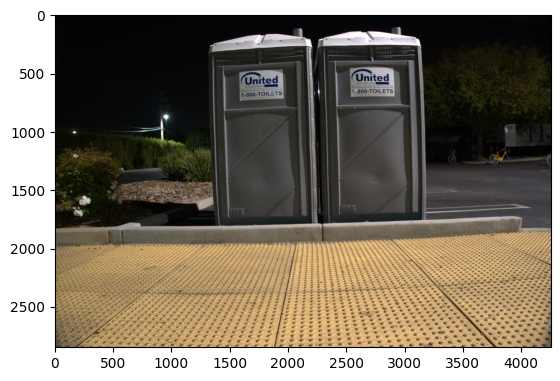

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_07_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_08_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_09_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_01_0.

 18%|█▊        | 18/100 [03:39<16:37, 12.16s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

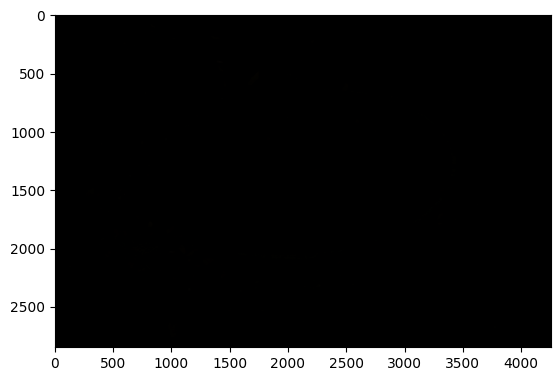

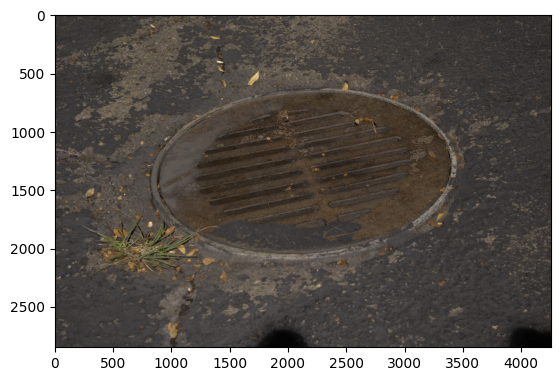

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_02_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_02_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_03_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_04_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_05_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_06_0.1

 19%|█▉        | 19/100 [03:52<16:37, 12.32s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

 20%|██        | 20/100 [04:02<15:37, 11.72s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')


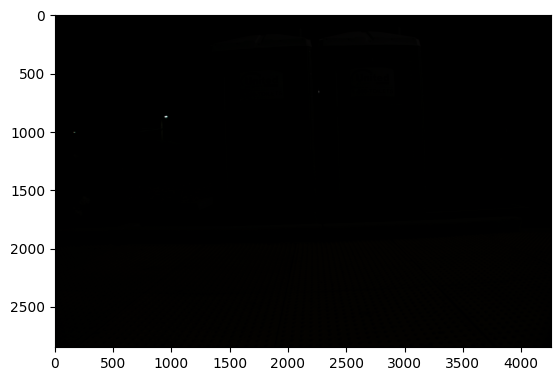

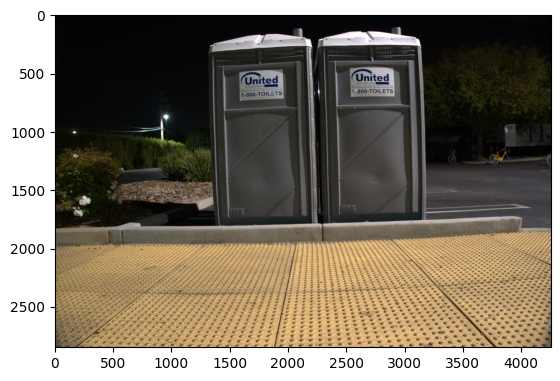

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_05_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_06_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_07_0.1s

 21%|██        | 21/100 [04:15<15:50, 12.04s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

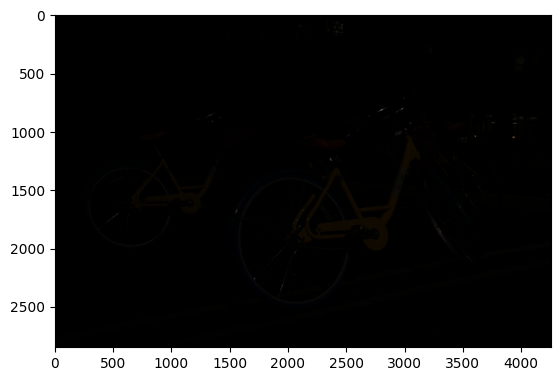

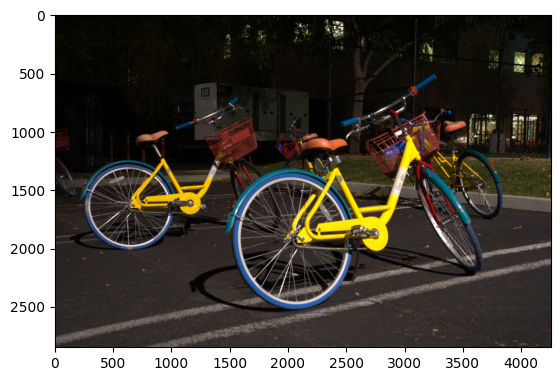

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_07_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_08_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_09_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_01_0.

 22%|██▏       | 22/100 [04:28<15:54, 12.24s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

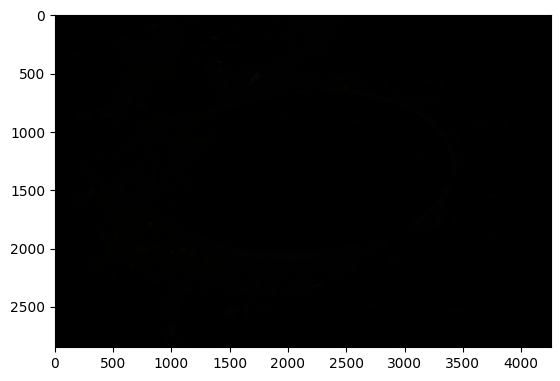

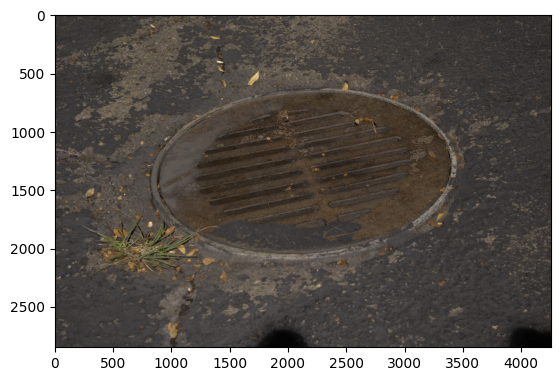

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00099_08_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00174_05_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00206_06_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00099_00_30s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00174_00_30s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00206_00_10s.ARW')


 23%|██▎       | 23/100 [04:40<15:51, 12.36s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

 24%|██▍       | 24/100 [04:51<15:07, 11.94s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

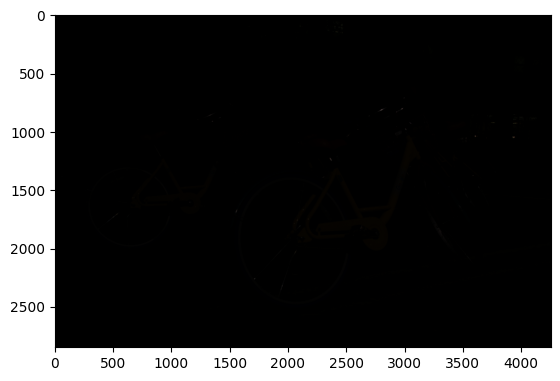

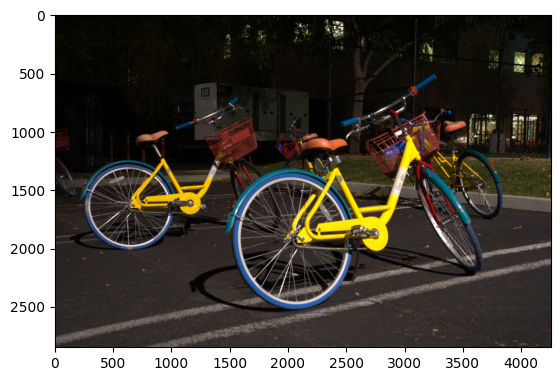

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_04_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_05_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00002_06_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00002_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00002_07_0.1s

 25%|██▌       | 25/100 [05:04<15:17, 12.24s/it]

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.04s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_00_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.04s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_01_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00001_03_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00001_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00001_04_0.

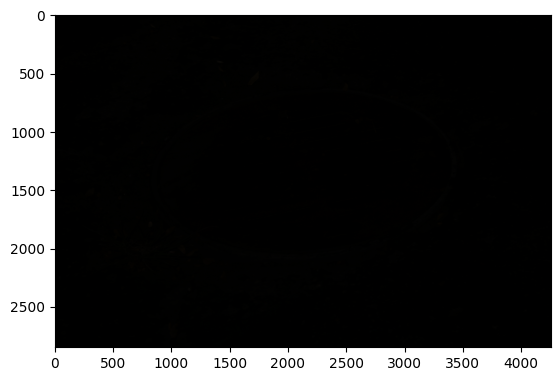

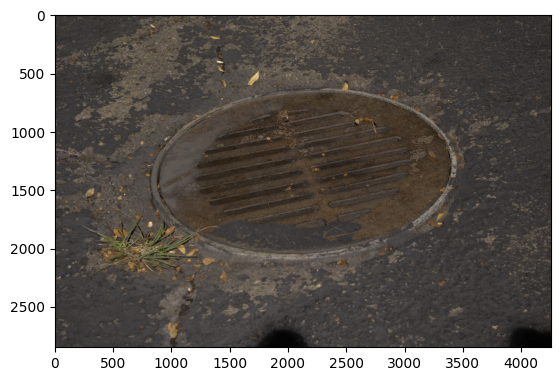

 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_06_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_07_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00004_08_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00004_09_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00010_02_0.1s.ARW', '/home/deeplearning/images/SonyImages/Sony/short/00021_04_0.1s.ARW')
('/home/deeplearning/images/SonyImages/Sony/long/00004_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00010_00_10s.ARW', '/home/deeplearning/images/SonyImages/Sony/long/00021_00_10s.ARW')
 ------------ new batch --------------
('/home/deeplearning/images/SonyImages/Sony/short/00099_08_0.1s

 25%|██▌       | 25/100 [05:17<15:52, 12.70s/it]


KeyboardInterrupt: 

In [32]:
####### SAMPLE INPUT DATA #######
# labels_dir = '/home/deeplearning/images/SonyImages/Sony/long/'
# images_dir = '/home/deeplearning/images/SonyImages/Sony/short/'

# # read all images in the directories
# images = glob.glob(images_dir + '*.ARW')
# labels = glob.glob(labels_dir + '*.ARW')


# # sort the images and labels
# images.sort()
# labels.sort()

# print(images)
# print(labels)

# # only train on 10 images, discard the rest
# images = images[:10]
# labels = labels[:10]

epoch_loss = 0
cnt = 0

# loop over epochs with tqdm progress bar
t = trange(n_epochs, leave=True)
for epoch in t:
    # initialize the training and validation loss for this epoch
    train_loss_epoch = 0.0
    valid_loss_epoch = 0.0

    # set the model to training mode
    Net.train()


    # loop over the training data
    #### IMPORTANT ####
    # len(images) == 3, if we are in the small size, so perhaps we can
    # heuristically increase this in order to get better results
    # sinze now it's just 3 images per epoch
    for input, label in dataloader:
        # load the first image and label
        print(' ------------ new batch --------------')
        print(input)
        print(label)
        
        input = input[0]
        label = label[0]


        image = rawpy.imread(input)
        label = rawpy.imread(label)

        # convert the image and label to numpy arrays
        image = image.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
        label = label.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)

        # convert the image and label to float32 data type
        image = np.float32(image / 65535.0)
        label = np.float32(label / 65535.0)

                # strip input and label from paranthese
        if cnt % 20 == 0:
                    # display the image and label
            plt.imshow(image)
            plt.show()
            plt.imshow(label)
            plt.show()



        ####### POSTPROCESSING #######

        # crop the image and label to 512 x 512
        image, label = random_crop(image, label, patch_size)

        # convert the image and label to tensors
        image = torch.from_numpy(np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0))
        label = torch.from_numpy(np.expand_dims(np.transpose(label, (2, 0, 1)), axis=0))

        # move the image and label to the device
        image, label = image.to(device), label.to(device)

        # forward pass
        output = Net(image)

        # calculate the loss
        loss = criterion(output, label)

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # clear the gradients
        optimizer.zero_grad()

        # print the loss
        # print("==> Loss: {}".format(loss.item()))
        epoch_loss = loss.item()

        # update the training loss
        train_loss_epoch += loss.item()

        # append loss to the list
        train_loss.append(loss.item())

        cnt = cnt + 1  

        # clear output
        del output
        

# plot loss
plt.plot(train_loss)
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# plot 